In [643]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter
import glob
import string

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler


# Carregar Dados

In [644]:
files=glob.glob('../archive/*.csv')
files

['../archive/parque_chapada_dos_veadeiros.csv',
 '../archive/mercado-ver-o-peso-pa.csv',
 '../archive/beto-carreiro-sc.csv',
 '../archive/pelourinho_ba.csv',
 '../archive/praia-copacabana-rj.csv',
 '../archive/museu_imperial.csv',
 '../archive/praca-3-poderes-br.csv',
 '../archive/museu_arte_sp.csv',
 '../archive/jardim_botanico.csv',
 '../archive/elevador_lacerda.csv',
 '../archive/aqua-rio-rj.csv',
 '../archive/parque_jalapao.csv',
 '../archive/parque_nacional_iguacu.csv',
 '../archive/mercado-central-fortaleza-ce.csv',
 '../archive/hopi_hari.csv']

In [645]:
#dados será um dicionário com os comentários e as notas de cada usuário
# as chaves do dicionário são os nomes dos destinos turísticos

dados={}

for file in files:
    dados[file.split('/')[-1].split('.')[0]]=pd.read_csv(file, delimiter=';')



In [646]:
dados.keys()
nomes_destinos=list(dados.keys())

# Análise Exploratória - Notas

## Comparativo entre as notas das atrações

In [647]:
#Verificando a existência de entradas nulas
print('Número de entradas nulas para as notas das atrações:')
print('')
for nome in nomes_destinos:
    print(nome+ ' : {}'.format(dados[nome]['nota'].isnull().sum()))

Número de entradas nulas para as notas das atrações:

parque_chapada_dos_veadeiros : 0
mercado-ver-o-peso-pa : 0
beto-carreiro-sc : 0
pelourinho_ba : 0
praia-copacabana-rj : 0
museu_imperial : 0
praca-3-poderes-br : 0
museu_arte_sp : 0
jardim_botanico : 0
elevador_lacerda : 0
aqua-rio-rj : 0
parque_jalapao : 0
parque_nacional_iguacu : 0
mercado-central-fortaleza-ce : 0
hopi_hari : 0


In [648]:
 
def calcular_proporcao_notas(dados):
    '''
    Função exibe o número de votos que atribuiu cada nota e a proporção desse número de votos em relação ao total 
    de votos para a atração selecionada

    input - dicionário com conjunto de dados para cada atração

    '''
    cont=0
    print('Número correpondente a cada atração')
    for i in dados.keys():
        print(str(cont) +'-' +i )
        cont+=1
    
    
    num=None
    while num not in np.arange(0,15):
        try:
            num=input('Selecione a atração (digite o número correpondente a atração desejada ou -1 para sair): ')
            num=int(num)
            if num not in np.arange(0,15):
                raise Exception()
        except:
            if num==-1:
                return None
            print('Entrada Inválida. Digite o número da atração desejada ou -1 para sair')
    nome_atracao=list(dados.keys())[num]
    dados_atracao=dados[nome_atracao]
    notas_atracao=dados_atracao.groupby('nota').agg(Número_de_Avaliações=('nota','count'))
    notas_atracao['Proporção de Avaliações']=notas_atracao['Número_de_Avaliações']/notas_atracao['Número_de_Avaliações'].sum()
    print('')
    print('Nome da atração: {}'.format(nome_atracao))
    print('Total de avaliações: {}'.format(notas_atracao['Número_de_Avaliações'].sum()))
    print(notas_atracao)
    

    
                 

In [649]:
proporcao_notas=[]
for destino in nomes_destinos:
    #x=dados[nome_atracao].groupby('nota').agg(Total=('nota','count'))
    proporcao_notas+=[[(dados[destino]['nota']==nota).sum() for nota in [1,2,3,4,5]]]
proporcao_notas=pd.DataFrame(proporcao_notas,index=nomes_destinos)
proporcao_notas["Total Avaliações"]=proporcao_notas.sum(axis=1)
proporcao_notas.iloc[:,:5]=proporcao_notas.iloc[:,:5].div(proporcao_notas["Total Avaliações"],axis=0)
proporcao_notas.columns=   ['nota 1(%)',
                            'nota 2(%)',
                            'nota 3(%)',
                            'nota 4(%)',
                            'nota 5(%)',
                             "Total Avaliações"]

In [650]:
proporcao_notas

,nota 1(%),nota 2(%),nota 3(%),nota 4(%),nota 5(%),Total Avaliações
parque_chapada_dos_veadeiros,0.002203,0.003672,0.021667,0.148366,0.824091,2723
mercado-ver-o-peso-pa,0.046576,0.079845,0.222345,0.319379,0.331855,3607
beto-carreiro-sc,0.093956,0.056684,0.080756,0.203572,0.565032,7727
pelourinho_ba,0.024637,0.040003,0.165692,0.352347,0.417321,11974
praia-copacabana-rj,0.011091,0.023617,0.117563,0.278314,0.569415,7664
museu_imperial,0.002822,0.005080,0.034994,0.247778,0.709327,7087
praca-3-poderes-br,0.006485,0.016537,0.150778,0.372568,0.453632,3084
museu_arte_sp,0.004138,0.010760,0.060420,0.275782,0.648899,6041
jardim_botanico,0.001403,0.003724,0.050498,0.253458,0.690916,20674
elevador_lacerda,0.026991,0.064808,0.278066,0.317959,0.312176,6743


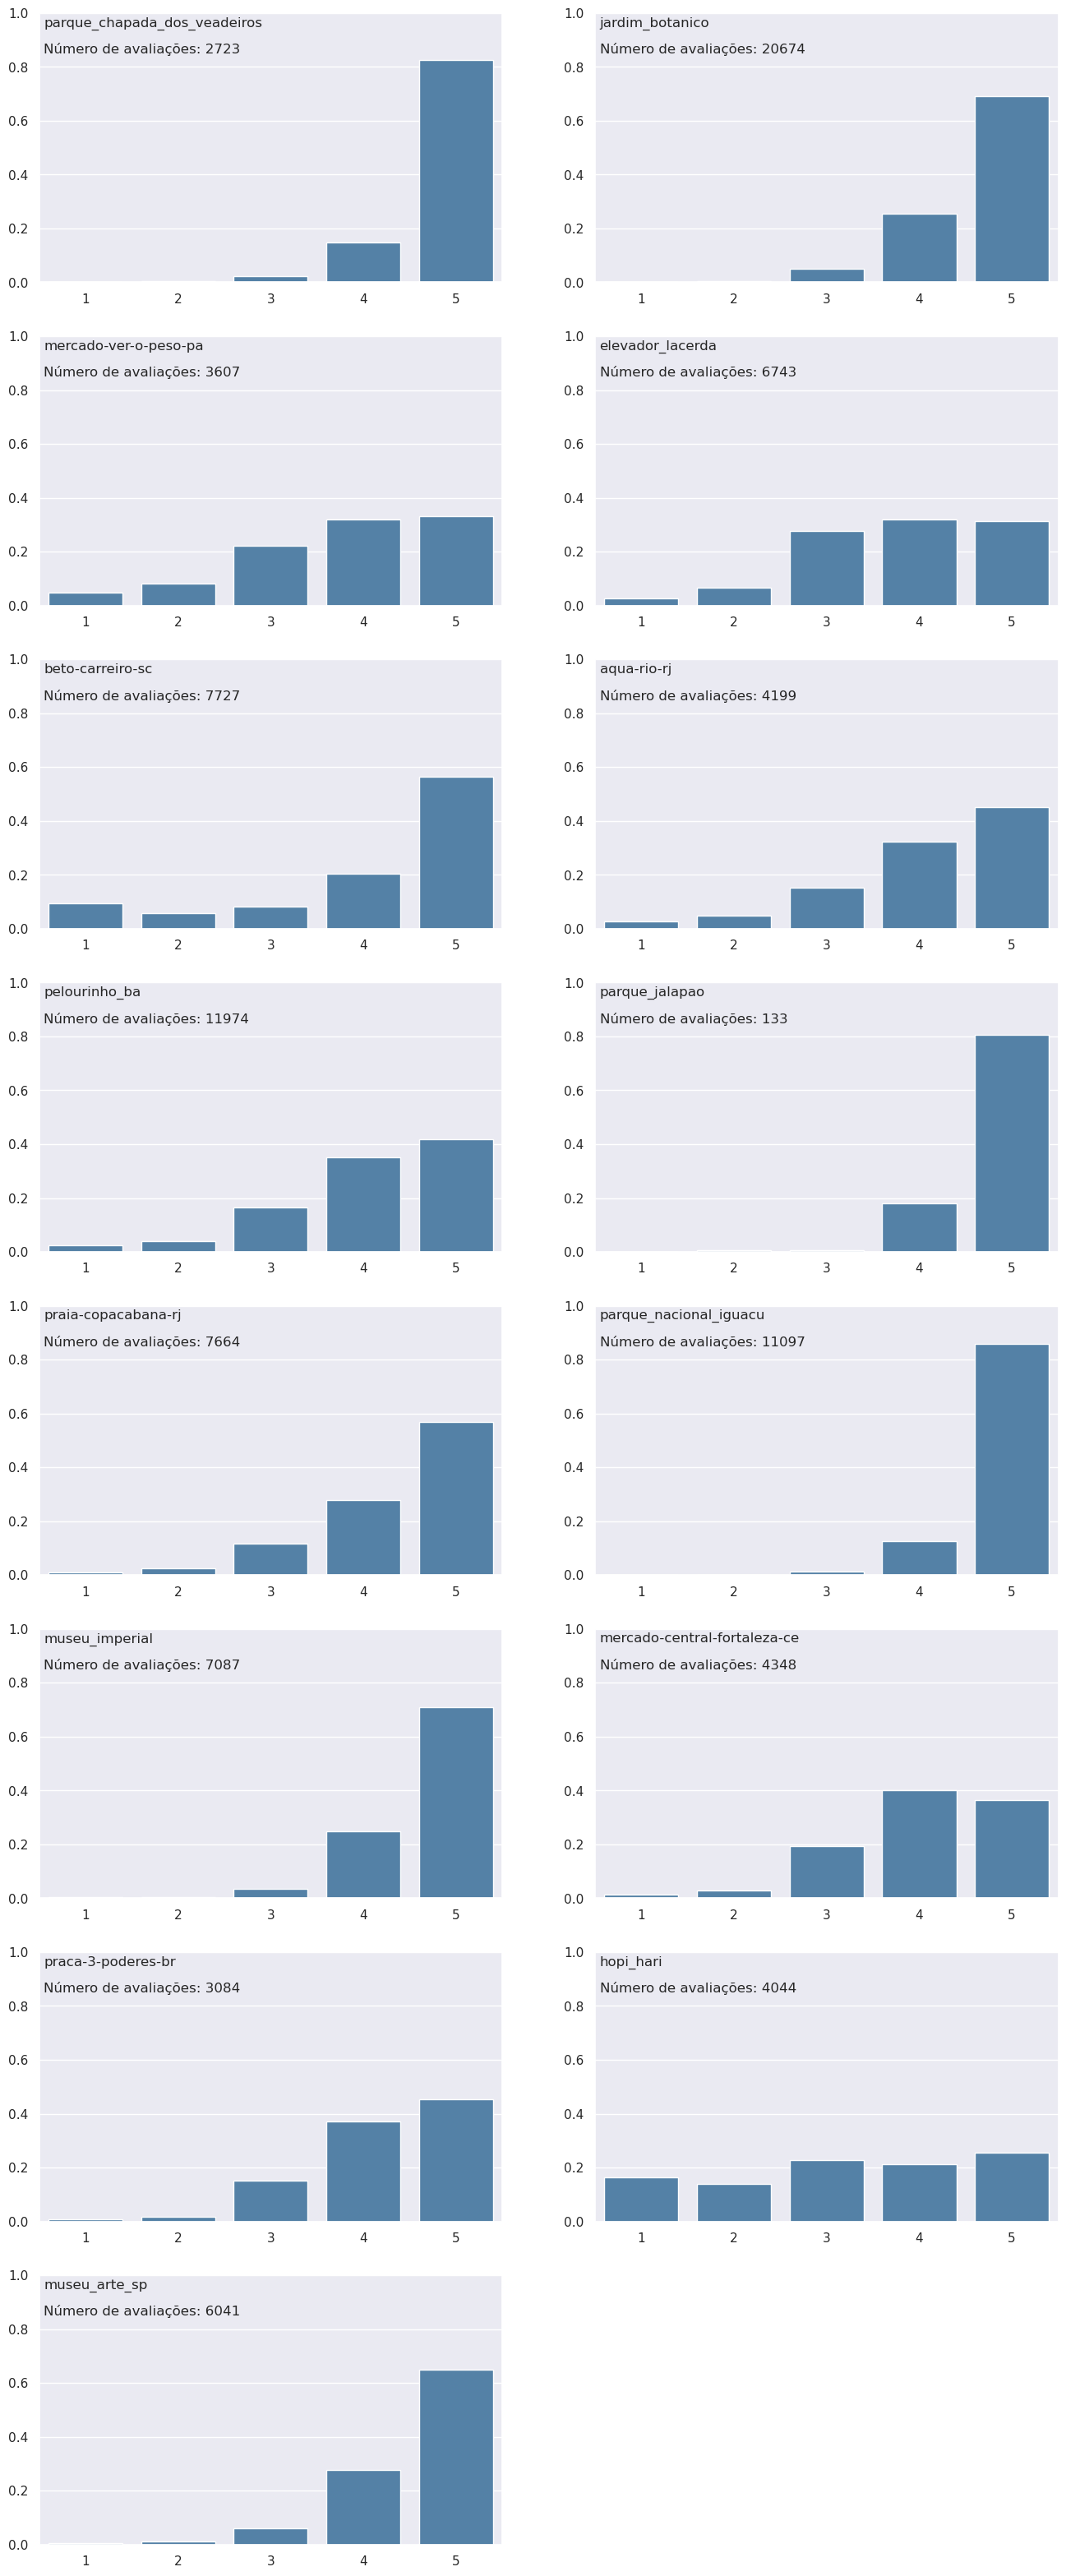

In [651]:
#Plotar graficos com as proporções das avaliações para cada atração
fig,axs=plt.subplots(8,2,figsize=(16,40))
sns.set_theme(style='darkgrid')
row_subplot=0
col_subplot=0
plt.title('Proporção das avaliações para cada atração')
for num_destino in range(len(proporcao_notas)):
    destino=proporcao_notas.index[num_destino]
    ax=sns.barplot(x=[1,2,3,4,5],y=proporcao_notas.iloc[num_destino,:5],ax=axs[row_subplot,col_subplot],color='steelblue')
    ax.text(-0.45, 0.95, destino)
    ax.text(-0.45, 0.85, "Número de avaliações: {}".format(proporcao_notas.loc[destino,'Total Avaliações']))
    ax.set(ylabel=None)
    ax.set_ylim(0,1)
    row_subplot+=1
    if row_subplot>7:
        row_subplot=0
        col_subplot=1
fig.delaxes(axs[7][1])


In [652]:
#Criação de dataframe com proporção de avaliações negativas, neutras e positivas

#Avaliação negativa - notas 1 e 2
#Avaliação neutra   - nota 3
#Avaliação positiva - notas 4 e 5


pos_neutra_neg=pd.concat((proporcao_notas.iloc[:,:2].sum(axis=1),
                          proporcao_notas.iloc[:,2],
                          proporcao_notas.iloc[:,3:5].sum(axis=1)),axis=1)
pos_neutra_neg.columns=['Negativas(%)',
                        'Neutras(%)',
                        'Positivas(%)']

pos_neutra_neg

,Negativas(%),Neutras(%),Positivas(%)
parque_chapada_dos_veadeiros,0.005876,0.021667,0.972457
mercado-ver-o-peso-pa,0.126421,0.222345,0.651234
beto-carreiro-sc,0.150641,0.080756,0.768604
pelourinho_ba,0.064640,0.165692,0.769668
praia-copacabana-rj,0.034708,0.117563,0.847730
museu_imperial,0.007902,0.034994,0.957105
praca-3-poderes-br,0.023022,0.150778,0.826200
museu_arte_sp,0.014898,0.060420,0.924681
jardim_botanico,0.005127,0.050498,0.944375
elevador_lacerda,0.091799,0.278066,0.630135


Text(0.5, 0, 'Destino')

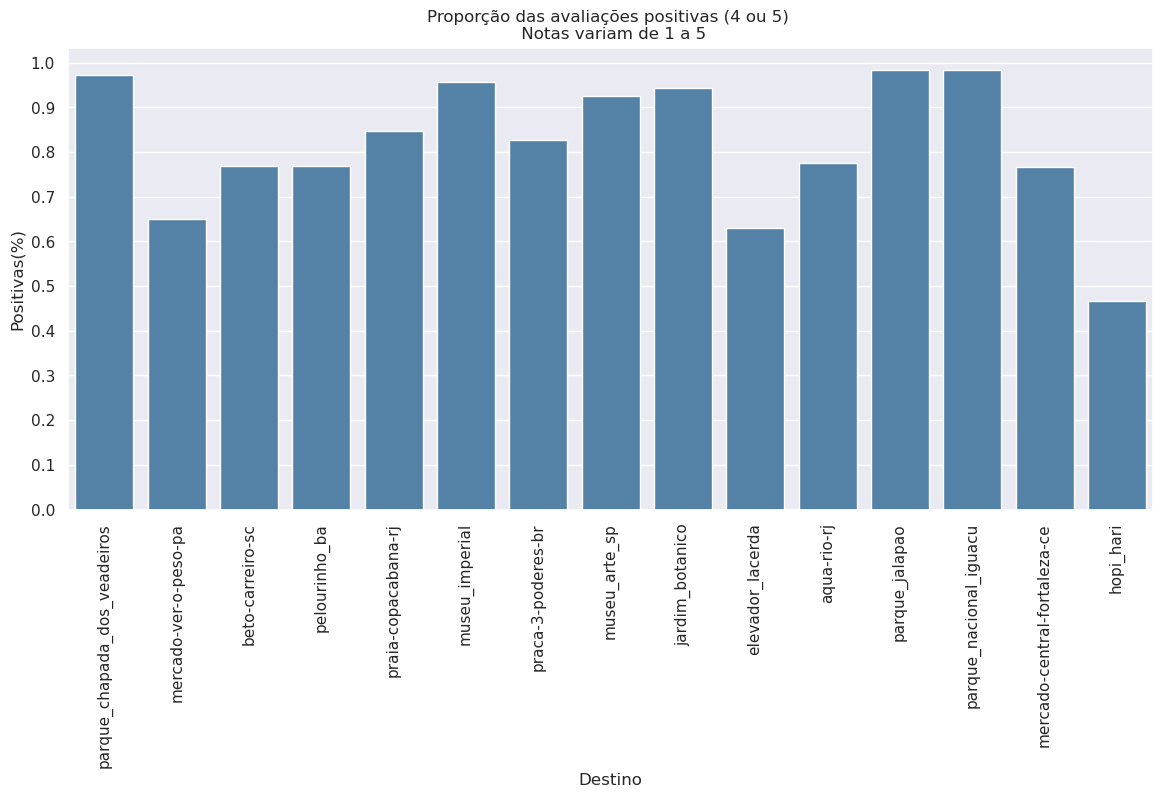

In [653]:
plt.figure(figsize=(14,6))
sns.set_theme(style='darkgrid')
plt.xticks(rotation=90)
plt.title('Proporção das avaliações positivas (4 ou 5) \n Notas variam de 1 a 5')
g=sns.barplot(pos_neutra_neg,x=pos_neutra_neg.index,y=pos_neutra_neg['Positivas(%)'],color='steelblue')
g.set(yticks=np.arange(0,1.1,0.1))
plt.xlabel('Destino')


Text(0.5, 0, 'Destino')

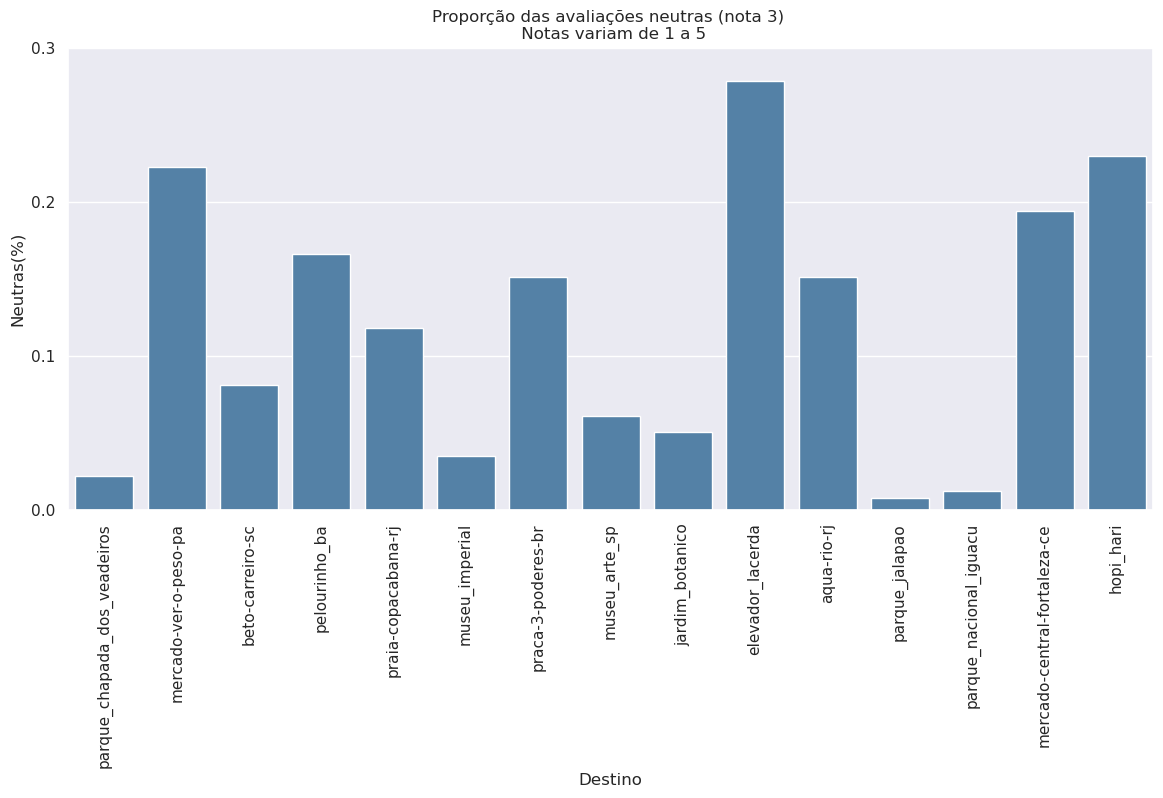

In [654]:
plt.figure(figsize=(14,6))
sns.set_theme(style='darkgrid')
plt.xticks(rotation=90)
plt.title('Proporção das avaliações neutras (nota 3) \n Notas variam de 1 a 5')
g=sns.barplot(pos_neutra_neg,x=pos_neutra_neg.index,y=pos_neutra_neg['Neutras(%)'],color='steelblue')
g.set(yticks=np.arange(0,0.4,0.1))
plt.xlabel('Destino')

[[<matplotlib.axis.YTick at 0x718a16b72610>,

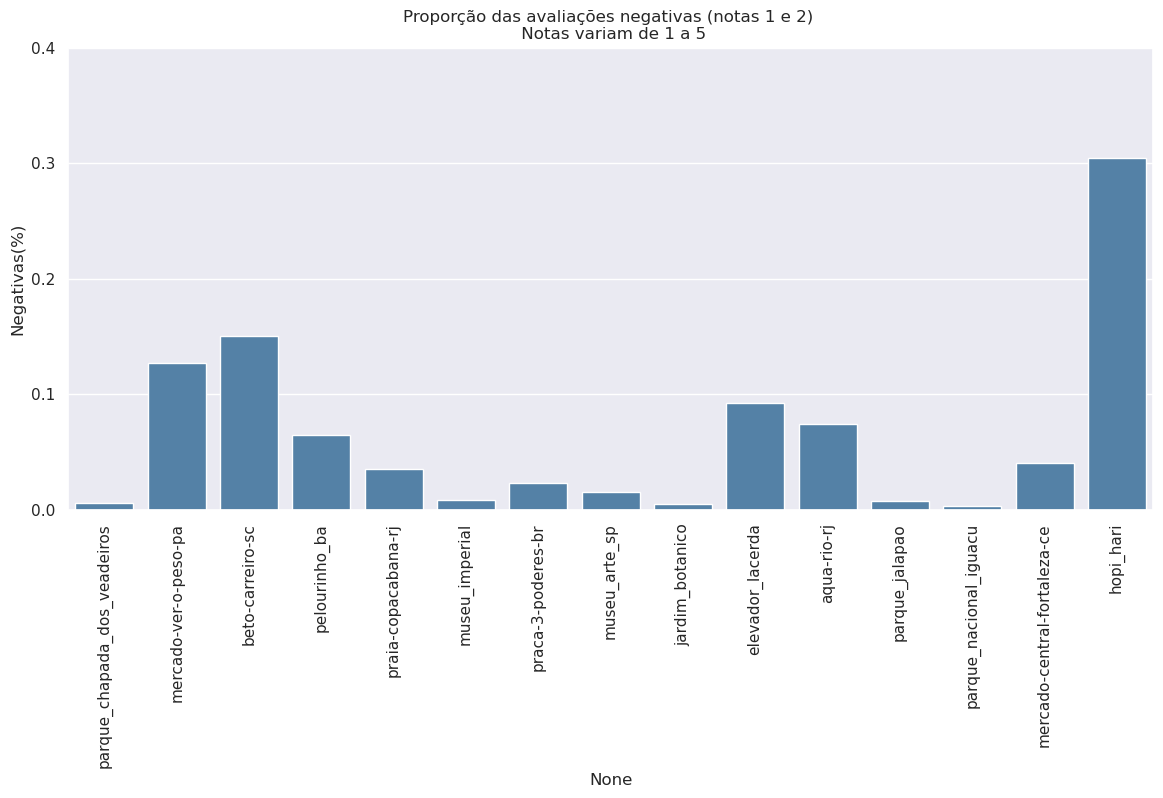

In [655]:
plt.figure(figsize=(14,6))
sns.set_theme(style='darkgrid')
plt.xticks(rotation=90)
plt.title('Proporção das avaliações negativas (notas 1 e 2) \n Notas variam de 1 a 5')
g=sns.barplot(pos_neutra_neg,x=pos_neutra_neg.index,y=pos_neutra_neg['Negativas(%)'],color='steelblue')
g.set(yticks=np.arange(0,0.5,0.1))

In [656]:
'''
#Plotar graficos com as proporções das avaliações para cada atração
fig,axs=plt.subplots(8,2,figsize=(16,40))
row_subplot=0
col_subplot=0
for atracao in nome_atracoes:
    notas_atracao=dados[atracao]
    notas_atracao=notas_atracao.groupby('nota').agg(Número_de_Avaliações=('nota','count'))
    notas_atracao['Proporção de Avaliações']=notas_atracao['Número_de_Avaliações']/notas_atracao['Número_de_Avaliações'].sum()
    notas_atracao.reset_index(inplace=True)
    ax=sns.barplot(notas_atracao,x='nota',y='Proporção de Avaliações',ax=axs[row_subplot,col_subplot],color='steelblue')
    ax.text(-0.45, 0.95, atracao)
    ax.text(-0.45, 0.85, "Número de avaliações: {}".format(notas_atracao['Número_de_Avaliações'].sum()))
    ax.set_ylim(0,1)
    row_subplot+=1
    if row_subplot>7:
        row_subplot=0
        col_subplot=1
fig.delaxes(axs[7][1])
'''

'\n#Plotar graficos com as proporções das avaliações para cada atração\nfig,axs=plt.subplots(8,2,figsize=(16,40))\nrow_subplot=0\ncol_subplot=0\nfor atracao in nome_atracoes:\n    notas_atracao=dados[atracao]\n    notas_atracao=notas_atracao.groupby(\'nota\').agg(Número_de_Avaliações=(\'nota\',\'count\'))\n    notas_atracao[\'Proporção de Avaliações\']=notas_atracao[\'Número_de_Avaliações\']/notas_atracao[\'Número_de_Avaliações\'].sum()\n    notas_atracao.reset_index(inplace=True)\n    ax=sns.barplot(notas_atracao,x=\'nota\',y=\'Proporção de Avaliações\',ax=axs[row_subplot,col_subplot],color=\'steelblue\')\n    ax.text(-0.45, 0.95, atracao)\n    ax.text(-0.45, 0.85, "Número de avaliações: {}".format(notas_atracao[\'Número_de_Avaliações\'].sum()))\n    ax.set_ylim(0,1)\n    row_subplot+=1\n    if row_subplot>7:\n        row_subplot=0\n        col_subplot=1\nfig.delaxes(axs[7][1])\n'

In [657]:
#Avaliar datas

# Análise Exploratória - Comentários

##  Dataset

In [658]:
#Agrupar os dados de todos os destinos em um mesmo dataframe

for nome_destino in nomes_destinos:
    dados[nome_destino]['destino']=nome_destino
df_dados=pd.concat([dados[destino] for destino in nomes_destinos],axis=0)

In [659]:
df_dados.head()

,comentario,nota,data,destino
0,O parque é lindo. Fizemos a Trilha dos Saltos ...,5.0,fev de 2023,parque_chapada_dos_veadeiros
1,Impossível descrever com palavras oq só presen...,5.0,fev de 2023,parque_chapada_dos_veadeiros
2,Eu fiz a trilha vermelha e o visual é de tirar...,5.0,jan de 2023,parque_chapada_dos_veadeiros
3,"Um lugar lindo, cheio de possibilidades, trilh...",5.0,jan de 2023,parque_chapada_dos_veadeiros
4,"Um dia em Alto Paraiso de Goias, que fazer? Co...",5.0,dez de 2022,parque_chapada_dos_veadeiros


In [660]:
x_comentarios=df_dados[['comentario']]
y_notas      =df_dados[['nota']]

In [661]:
#Dataset desbalanceado, são poucas avaliações com 1 ou 2 estrelas
y_notas.value_counts()

nota
5.0     58040
4.0     26829
3.0     10902
2.0      2974
1.0      2400
Name: count, dtype: int64

In [662]:
#Aproximadamente 57% das avaliações receberam nota 5
y_notas.value_counts()/len(y_notas)

nota
5.0     0.573830
4.0     0.265253
3.0     0.107786
2.0     0.029403
1.0     0.023728
Name: count, dtype: float64

In [663]:
proporcao_notas_negativas=100*(y_notas.value_counts()[3:].sum())/len(y_notas)
print('Proporção das avaliações com notas 1 ou 2: {}%'.format(proporcao_notas_negativas))

Proporção das avaliações com notas 1 ou 2: 5.313164269118592%


In [664]:
#O conjunto de dados seŕa dividido em treino e teste (80% para treino e 20% para teste)
x_treino,x_teste,y_treino,y_teste=train_test_split(x_comentarios,y_notas,test_size=0.2,stratify=y_notas,random_state=42)

In [665]:
#A separação dos dados de treino e teste foi feito de modo estratificado, de modo que a propoção de amostras de cada classe foi mantida após a separação
proporcao_treino_teste=pd.concat((y_notas.value_counts()/len(y_notas),
                        y_treino.value_counts()/len(y_treino),
                        y_teste.value_counts()/len(y_teste)),axis=1).rename(columns={0:'conjunto total',1:'treino',2:'teste'})
proporcao_treino_teste.columns=['Total','Treino','Teste']
proporcao_treino_teste

,Total,Treino,Teste
nota,,,
5.0,0.573830,0.573830,0.573830
4.0,0.265253,0.265250,0.265263
3.0,0.107786,0.107791,0.107766
2.0,0.029403,0.029401,0.029413
1.0,0.023728,0.023728,0.023728


In [666]:
#Numero de amostras de cada nota nos dados de treino e teste
amostras_treino_teste=pd.concat((y_treino.value_counts(),y_teste.value_counts()),axis=1)
amostras_treino_teste.columns=['Treino','Teste']
amostras_treino_teste

,Treino,Teste
nota,,
5.0,46432,11608
4.0,21463,5366
3.0,8722,2180
2.0,2379,595
1.0,1920,480


In [667]:
#num_col_nota=list(df_dados.columns).index('nota')
#num_col_comentario=list(df_dados.columns).index('comentario')

## Pré-processamento dos comentários

### Remoção da pontuação dos comentários e conversão de todas as letras para minúsculas


In [668]:
#Remover pontuação dos comentários usando o método translate
#x_treino_pp são os dados de treinamento com o pré-processamento
x_treino_pp=x_treino.copy()
x_treino_pp['comentario']=x_treino_pp['comentario'].apply(lambda x:x.translate(str.maketrans('','',string.punctuation)))
x_treino_pp['comentario']=x_treino_pp['comentario'].apply(lambda x:x.lower())

print('Com pontuação e letras maiúsculas e minúsculas: {}'.format(x_treino.iloc[0,0]))
print('Sem pontuação e somente letras minúsculas: {}'.format(x_treino_pp.iloc[0,0]))


Com pontuação e letras maiúsculas e minúsculas: Presenciei dois assaltos e meu taxista havia sido roubado a poucos dias. Mto perigoso!! Não ande com celular à mostra nem dinheiro nem nada de valor. Não fique pescando! Foque no que você quer e tome cuidado com seus pertences!Comida gostosa, porém muito movimentado e muita poluição sonora!
Sem pontuação e somente letras minúsculas: presenciei dois assaltos e meu taxista havia sido roubado a poucos dias mto perigoso não ande com celular à mostra nem dinheiro nem nada de valor não fique pescando foque no que você quer e tome cuidado com seus pertencescomida gostosa porém muito movimentado e muita poluição sonora


### Análise da frequência que cada palavra aparece nos comentários com cada nota

'''
O número de comentários com cada nota é muito diferente, dificultando a comparação da frequência de aparição de cada palavra em comentários com notas diferentes. Para solucionar essa dificuldade serão selecionados de forma aleatória do conjunto de dados de treino número igual de comentários com cada nota
'''

In [669]:
#Selecionar de forma aleatória número igual de comentários com cada nota
#x_res_pp são os dados amsotrados com pré processamento
#x_res são os dados amosrtados sem o pré processamento (serçao mantidos para melhor visualização)

resampler=RandomUnderSampler(random_state=42)
x_res_pp,y_res=resampler.fit_resample(x_treino_pp,y_treino)
x_res,_=resampler.fit_resample(x_treino,y_treino)

In [670]:
amostras_original_resampled=pd.concat((y_treino.value_counts(),y_res.value_counts()),axis=1)
amostras_original_resampled.columns=['Original',"Resampled"]
amostras_original_resampled

,Original,Resampled
nota,,
5.0,46432,1920
4.0,21463,1920
3.0,8722,1920
2.0,2379,1920
1.0,1920,1920


In [671]:
#Contar o número de vezes que cada palavra aparece nos comentários com a mesma nota e também o número total de vezes que cada palavra aparece
#Para essa contagem serão usados os dados com mesmo número de amostras de cada nota
nota1_count=Counter()
nota2_count=Counter()
nota3_count=Counter()
nota4_count=Counter()
nota5_count=Counter()
total_count=Counter()

In [672]:
for num_row in range(len(x_res)):
    if y_res.iloc[num_row,0]==1:
        for palavra in x_res_pp.iloc[num_row,0].split(" "):
            nota1_count[palavra]+=1
            total_count[palavra]+=1

    elif y_res.iloc[num_row,0]==2:
        for palavra in x_res_pp.iloc[num_row,0].split(" "):
            nota2_count[palavra]+=1
            total_count[palavra]+=1

    elif y_res.iloc[num_row,0]==3:
        for palavra in x_res_pp.iloc[num_row,0].split(" "):
            nota3_count[palavra]+=1
            total_count[palavra]+=1

    elif y_res.iloc[num_row,0]==4:
        for palavra in x_res_pp.iloc[num_row,0].split(" "):
            nota4_count[palavra]+=1
            total_count[palavra]+=1

    else:
        for palavra in x_res_pp.iloc[num_row,0].split(" "):
            nota5_count[palavra]+=1
            total_count[palavra]+=1

In [673]:
#Palavras mais comuns nos comentários com nota 1
nota1_count.most_common()

[('de', 5933),
 ('e', 5188),
 ('que', 4247),
 ('o', 4231),
 ('a', 3747),
 ('não', 3181),
 ('para', 2397),
 ('um', 2183),
 ('com', 1988),
 ('parque', 1975),
 ('em', 1948),
 ('no', 1803),
 ('do', 1794),
 ('é', 1760),
 ('', 1742),
 ('uma', 1391),
 ('mais', 1301),
 ('na', 1216),
 ('os', 1157),
 ('se', 1127),
 ('brinquedos', 1066),
 ('fila', 1052),
 ('as', 1044),
 ('da', 1009),
 ('muito', 910),
 ('por', 888),
 ('filas', 817),
 ('sem', 737),
 ('mas', 714),
 ('ao', 714),
 ('tem', 694),
 ('pra', 658),
 ('foi', 649),
 ('dia', 638),
 ('ir', 601),
 ('pessoas', 575),
 ('horas', 545),
 ('dos', 531),
 ('só', 489),
 ('ou', 484),
 ('como', 481),
 ('lugar', 475),
 ('estava', 469),
 ('já', 468),
 ('fui', 437),
 ('atrações', 421),
 ('você', 416),
 ('pois', 410),
 ('era', 408),
 ('brinquedo', 408),
 ('ser', 396),
 ('minha', 390),
 ('nos', 389),
 ('eu', 388),
 ('lá', 376),
 ('isso', 372),
 ('local', 365),
 ('mesmo', 363),
 ('são', 363),
 ('até', 355),
 ('tudo', 352),
 ('das', 348),
 ('nem', 341),
 ('me', 3

In [674]:
#Palavras mais comuns nos comentários com nota 5

nota5_count.most_common()

[('e', 3054),
 ('de', 2856),
 ('a', 2328),
 ('o', 2222),
 ('é', 1722),
 ('para', 1473),
 ('que', 1374),
 ('com', 1217),
 ('um', 1155),
 ('', 1141),
 ('do', 1090),
 ('muito', 1072),
 ('uma', 801),
 ('não', 771),
 ('em', 730),
 ('da', 708),
 ('parque', 628),
 ('as', 627),
 ('no', 610),
 ('os', 607),
 ('bem', 579),
 ('lugar', 561),
 ('tem', 487),
 ('se', 452),
 ('mais', 425),
 ('na', 406),
 ('vale', 367),
 ('são', 360),
 ('mas', 357),
 ('pena', 337),
 ('passeio', 325),
 ('ao', 322),
 ('lindo', 320),
 ('local', 318),
 ('por', 317),
 ('dos', 282),
 ('das', 267),
 ('como', 244),
 ('conhecer', 244),
 ('jardim', 240),
 ('tudo', 232),
 ('visita', 231),
 ('ir', 231),
 ('museu', 219),
 ('todos', 213),
 ('dia', 207),
 ('cidade', 203),
 ('você', 203),
 ('quem', 199),
 ('nos', 197),
 ('curitiba', 195),
 ('foi', 191),
 ('bom', 182),
 ('ou', 179),
 ('pois', 179),
 ('lá', 176),
 ('cuidado', 172),
 ('fotos', 170),
 ('ser', 169),
 ('visitar', 168),
 ('pra', 166),
 ('família', 165),
 ('sem', 159),
 ('pelo

In [675]:
#Palavras menos comuns nos comentários com nota 5
nota5_count.most_common()[-1:-20:-1]

[('complementa', 1),
 ('surpreendem', 1),
 ('tonalidade', 1),
 ('fofa', 1),
 ('olinda', 1),
 ('tempolembra', 1),
 ('irrisório', 1),
 ('canga', 1),
 ('desenho', 1),
 ('corriam', 1),
 ('sentiram', 1),
 ('corrervale', 1),
 ('normas', 1),
 ('aspecto', 1),
 ('recém', 1),
 ('exemplificadas', 1),
 ('nítidas', 1),
 ('criticar', 1),
 ('aplaudir', 1)]

In [676]:
#Palavras menos comuns nos comentários com nota 1
nota1_count.most_common()[-1:-20:-1]

[('voltamosa', 1),
 ('tomamos', 1),
 ('compartilhar', 1),
 ('algodao', 1),
 ('cade', 1),
 ('cheiram', 1),
 ('reparo', 1),
 ('ligados', 1),
 ('mtooo', 1),
 ('melhorem', 1),
 ('percorrida', 1),
 ('acarretando', 1),
 ('tivéssemos', 1),
 ('fuidesorganizado', 1),
 ('cmpraram', 1),
 ('doque', 1),
 ('brinquedospraça', 1),
 ('prejuízonão', 1),
 ('confortavelmente', 1)]

'''
Comparando os comentários com nota 1 e os comentários com nota 5, é possível notar que as palavras mais frequentes em ambos se repetem, são preposições e artigos como por exemplo e,a,que,de,do. Esse tipo de palavra aparece comunmente em qualquer frase e não serve para caracterizar um  comentário. Deve-se buscar palavras que aparecem com mais frequência em comentários com determinada nota, espera-se por exemplo que uma palavra como excelente apareça com maior frequência em comentários com nota 5.

Já verificando as palavras que aparecem com menor frequência, verifica-se a ocorrência de palavras incomuns, com grafia errada e com erros de digitação. Palavras que aparecem raramente não podem ser empregadas para caracterizar um conjunto de comentários.

Sendo assim buscar-se-á remover as palavras com muitas ocorrências e as com muito poucoas ocorrências.

'''

'''
Para comparar as palavras que aparecem com maior frequência em cada nota, será calculada a razão entre o número de vezes que cada palavra aparece em comentários com certa
nota e o número de vezes em que a palavra apareceu em todos os comentários. Por exemplo, caso a palavra excelente apareça somente em comentários com nota 5, a razão para essa 
palavra será cinco para nota 5 e 0 para os demais. Ou seja, palavram que apareçam com maior frequência em comentários com certa nota terão razao mais próximas de 1.

'''

In [677]:
def calcular_razao(counter_nota,counter_total,min_freq):
    '''
    Função para calcular a razão entre o numero de vezes que a palavra aparece em comentários com certa nota e o nḿero de vezes que a palavra aparece em 
    todos os comentários

    inputs:
    counter_nota  - objeto Counter com número de vezes que as palavras aparerem em comentários com certa nota
    counter_total - objeto Counter com número de vezes que as palavras aparerem no conjunto de todos os comentrários
    min_freq      - número mínimo de vezes que uma palavra deve aparecer para ser consideradas. Palavras raras não são úteis para caracterizar os comentários
    '''
    razao=Counter()
    for palavra in counter_nota:
        if counter_nota[palavra]>min_freq:
            razao[palavra]=counter_nota[palavra]/counter_total[palavra]
    return razao
    

min_freq=100 #Palavra deve ter aparecido no mínimo cem vezes para ser considerada

razao_nota5=calcular_razao(nota5_count,total_count,min_freq)
razao_nota4=calcular_razao(nota4_count,total_count,min_freq)
razao_nota3=calcular_razao(nota3_count,total_count,min_freq)
razao_nota2=calcular_razao(nota2_count,total_count,min_freq)
razao_nota1=calcular_razao(nota1_count,total_count,min_freq)

In [678]:
razao_nota5.most_common()

[('natureza', 0.6682926829268293),
 ('cataratas', 0.6566265060240963),
 ('maravilhoso', 0.5776699029126213),
 ('curitiba', 0.5635838150289018),
 ('beleza', 0.47555555555555556),
 ('lindo', 0.45977011494252873),
 ('botânico', 0.45907473309608543),
 ('limpo', 0.45051194539249145),
 ('excelente', 0.42907801418439717),
 ('jardim', 0.40609137055837563),
 ('ótimo', 0.4037433155080214),
 ('museu', 0.3680672268907563),
 ('família', 0.3634361233480176),
 ('brasil', 0.3074792243767313),
 ('passeio', 0.3057384760112888),
 ('super', 0.29397590361445786),
 ('fotos', 0.2838063439065108),
 ('história', 0.280561122244489),
 ('visitar', 0.26373626373626374),
 ('conhecer', 0.24897959183673468),
 ('lugar', 0.2435953104646114),
 ('bem', 0.24358435002103493),
 ('fazer', 0.23809523809523808),
 ('visita', 0.22602739726027396),
 ('vale', 0.22501532801961988),
 ('pena', 0.2185473411154345),
 ('à', 0.21338155515370705),
 ('todos', 0.21089108910891088),
 ('cuidado', 0.20476190476190476),
 ('muito', 0.20395738203

In [679]:
razao_nota1.most_common()

[('horrível', 0.7850467289719626),
 ('total', 0.7212121212121212),
 ('péssima', 0.6697674418604651),
 ('vip', 0.6686746987951807),
 ('volto', 0.6666666666666666),
 ('péssimo', 0.6544502617801047),
 ('brinquedo', 0.6507177033492823),
 ('respeito', 0.6402439024390244),
 ('pior', 0.6355555555555555),
 ('horas', 0.6172140430351076),
 ('ninguém', 0.597457627118644),
 ('site', 0.5833333333333334),
 ('fila', 0.580253723110866),
 ('espera', 0.5701219512195121),
 ('nunca', 0.5688775510204082),
 ('1', 0.5584045584045584),
 ('3', 0.553763440860215),
 ('4', 0.5376044568245125),
 ('absurdo', 0.5365853658536586),
 ('conseguimos', 0.5365853658536586),
 ('nenhum', 0.5344827586206896),
 ('ingressos', 0.5309734513274337),
 ('filas', 0.5298313878080415),
 ('5', 0.5275862068965518),
 ('hari', 0.5271565495207667),
 ('decepção', 0.5245098039215687),
 ('montanha', 0.5219512195121951),
 ('2', 0.5211726384364821),
 ('funcionando', 0.51875),
 ('experiência', 0.5181451612903226),
 ('hopi', 0.5167173252279635),
 

'''
Analisando as palavras que aparecem com maior frequência nos comentários com nota 5, as três primeiras são espeficas para certos destinos (trilhas,cataretas,natureza). Já a quarta palavra (maravilhoso) é uma palavra que é relacionada a comentários extremamente positivos.

Já para ps comentários com nota 1, encontramos palavras como horrível, péssimo, filas, etc.

'''

In [680]:
#Função para exibir o número de vezes que a palavra selecionada aparece nos comentários com cada nota
def numero_ocorrencias(palavra):
    '''
    Função para exibir o número de vezes que a palavra selecionada aparece nos comentários com cada nota
    A contagem será feita no conjunto de dados com mesmo número amostras de cada comentário para possibilitar a comparação

    Input
    palavra (palavra) - A palavra para a qual se deseja exibir a contagem 
    '''
    print('Número de vezes que a palavra {} apareceu nos comentários: '.format(palavra))
    print('')
    print('Nota 5: {}'.format(nota5_count[palavra]))
    print('Nota 4: {}'.format(nota5_count[palavra]))
    print('Nota 3: {}'.format(nota3_count[palavra]))
    print('Nota 2: {}'.format(nota2_count[palavra]))
    print('Nota 1: {}'.format(nota1_count[palavra]))


In [681]:
#Exibindo o número de ocorrências da palavra maravilhoso nos comentários com cada nota
#Interessante notar que a palavra maravilhoso aparece am alguns comentários com notas ruins
numero_ocorrencias('maravilhoso')

Número de vezes que a palavra maravilhoso apareceu nos comentários: 

Nota 5: 119
Nota 4: 119
Nota 3: 20
Nota 2: 7
Nota 1: 17


In [682]:
##Exibindo o número de ocorrências da palavra péssimo nos comentários com cada nota
numero_ocorrencias('péssimo')

Número de vezes que a palavra péssimo apareceu nos comentários: 

Nota 5: 1
Nota 4: 1
Nota 3: 14
Nota 2: 49
Nota 1: 125


In [685]:
#Vamos verificar exemplos de cometários negativos em que a palavra mamarilhoso aparece
neg_maravilhoso=[]
teste=[]
for row_comentario in range(len(y_res)):
    if (y_res.iloc[row_comentario,0]==1) and ('maravilhoso' in x_res_pp.iloc[row_comentario,0].split(' ')):
        neg_maravilhoso+=[x_res.iloc[row_comentario,0]] 

In [686]:
len(neg_maravilhoso)

17